In [1]:
# Use only 1 GPU if available
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline


c:\Users\arman\anaconda3\envs\chronos_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from raw_data.by_station.load_metadata import (
    load_velib_metadata, sample_stations_dataframe, to_datetime, to_time, 
    search_sorted, iter_time, plot_time,
    plot_space
)

meta = load_velib_metadata()

data = meta["data"]
station_offsets = meta["station_offsets"]
station_states = meta["station_states"]

features = meta["features"]
states = meta["states"]

✅ Dataset Velib chargé depuis raw_data/by_station/velib_dataset.mmap
 - 154,860,042 lignes
 - 11 colonnes : ('temps_absolu', 'etat_station', 'vm_disponibles', 'vae_disponibles', 'vm_indisponibles', 'vae_indisponibles', 'diapason_disponibles', 'vm_disponibles_station_plus', 'vae_disponibles_plus', 'vm_indisponibles_station_plus', 'vae_indisponibles_plus')
 - 1551 stations référencées
structure du dictionnaire d'offsets:
station '1007': {'2023-01': [5879577, 5885643], '2023-02': [5885643, 5891714],...


loading station 1120 in sample...
loading station 12008 in sample...
loading station 26002 in sample...
loading station 40016 in sample...
loading station 14030 in sample...
loading station 32305 in sample...
loading station 11114 in sample...
loading station 34010 in sample...
loading station 19045 in sample...
loading station 48008 in sample...
loading station 19036 in sample...
loading station 21024 in sample...
loading station 4014 in sample...
loading station 31303 in sample...
loading station 9017 in sample...
15 stations incluses


,temps_absolu,etat_station,vm_disponibles,vae_disponibles,vm_indisponibles,vae_indisponibles,diapason_disponibles,vm_disponibles_station_plus,vae_disponibles_plus,vm_indisponibles_station_plus,vae_indisponibles_plus,code_station,date_update
447175,0,0,9,5,0,0,18,0,0,0,0,11114,2023-01-01
0,0,0,7,0,1,2,17,0,0,0,0,1120,2023-01-01
142313,0,0,30,10,3,1,10,0,0,0,0,12008,2023-01-01
310649,0,1,0,0,0,0,32,0,0,0,0,14030,2023-01-01
887915,0,0,10,1,0,0,22,0,0,0,0,19036,2023-01-01


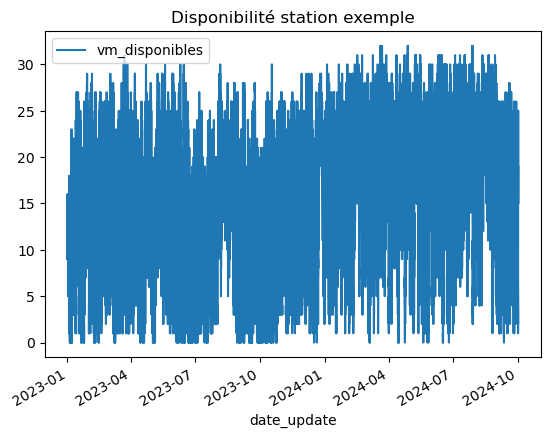

In [3]:
df_sample = sample_stations_dataframe(
    data=data,
    station_offsets=station_offsets,
    features=features,
    n_stations=15,
    start_month="2023-01",
    end_month="2024-09",
    to_datetime_func=to_datetime  
)

print(df_sample["code_station"].nunique(), "stations incluses")

# Visualisation rapide pour une station
df_sample.query("code_station == @df_sample['code_station'].iloc[0]").plot(
    x="date_update", y="vm_disponibles", title="Disponibilité station exemple"
)

df_sample.head()


In [4]:
from prepare_data.bike_processing import process_bike_data, complete_missing_hours
from prepare_data.external_features import add_meteo_features

df_meteo = pd.read_csv("prepare_data/meteo_2023_2025.csv")
df_sample = complete_missing_hours(process_bike_data(df_sample))
df_sample = df_sample.rename(columns = {"date_update": "date_day"})
df_sample = add_meteo_features(df_sample, df_meteo)

In [5]:
# Renommer les colonnes comme attendu par Chronos
context_df = df_sample.copy().rename(columns={
    "date_day": "timestamp", 
    "ratio": "target",
    "code_station": "item_id"
})

# S'assurer que la colonne start est bien datetime
context_df["timestamp"] = pd.to_datetime(context_df["timestamp"])

# Garder seulement les colonnes nécessaires
context_df = context_df[["timestamp", "target", "item_id", "TN","TX","TM","RR","DRR"]]

# Nombre d'heures de décalage
max_days = 7
lags = [24 * i for i in range(1, max_days + 1)]  # [24, 48, 72, 96, 120, 144, 168]

# On essaie de prédire sur une semaine
prediction_length = 24*7

# Pour chaque station, on crée les lags
def add_target_lags(df, lags):
    df = df.sort_values("timestamp").copy()
    for lag in lags:
        df[f"target_lag_{lag}"] = df["known_target"].shift(lag)
    return df

context_df["known_target"] = context_df["target"]


#pas de triche
context_df.loc[context_df.index[-prediction_length:], "known_target"] = pd.NA


context_df = (
    context_df.groupby("item_id", group_keys=False)
    .apply(lambda x: add_target_lags(x, lags))
)

context_df = context_df.drop(columns="known_target")

# Séparer les deux DataFrames
train_df = context_df.groupby("item_id").apply(lambda x: x.iloc[:-prediction_length]).reset_index(drop=True)
test_df = context_df.groupby("item_id").apply(lambda x: x.iloc[-prediction_length:]).reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("s3://autogluon/chronos-2/", device_map="cpu")

#pas de triche
future_df = test_df.drop(columns = "target")
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("s3://autogluon/chronos-2/", device_map="cpu")
pred_df = pipeline.predict_df(
    train_df,
    future_df = future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1,0.5,0.9],
    predict_batches_jointly=True,
    batch_size=100
)
print("Output dataframe shape:", pred_df.shape)
display(pred_df.head())

C:\Users\arman\AppData\Local\Temp\ipykernel_21092\2977968217.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: add_target_lags(x, lags))
C:\Users\arman\AppData\Local\Temp\ipykernel_21092\2977968217.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = context_df.groupby("item_id").apply(lambda x: x.iloc[:-prediction_length]).reset_index(drop=True)
C:\Users\arman\AppData\Local\Temp\ipyker

Train shape: (227520, 15)
Test shape: (2520, 15)


c:\Users\arman\anaconda3\envs\chronos_env\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Output dataframe shape: (2520, 7)


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,11114,2024-09-24 00:00:00,target,0.689986,0.560729,0.689986,0.792775
1,11114,2024-09-24 01:00:00,target,0.677994,0.498868,0.677994,0.824880
2,11114,2024-09-24 02:00:00,target,0.673786,0.471121,0.673786,0.837256
3,11114,2024-09-24 03:00:00,target,0.670971,0.453622,0.670971,0.844904
4,11114,2024-09-24 04:00:00,target,0.676025,0.446886,0.676025,0.845207


In [6]:
station_list = list(test_df["item_id"].unique())
print(station_list)

[np.str_('11114'), np.str_('1120'), np.str_('12008'), np.str_('14030'), np.str_('19036'), np.str_('19045'), np.str_('21024'), np.str_('26002'), np.str_('31303'), np.str_('32305'), np.str_('34010'), np.str_('40016'), np.str_('4014'), np.str_('48008'), np.str_('9017')]


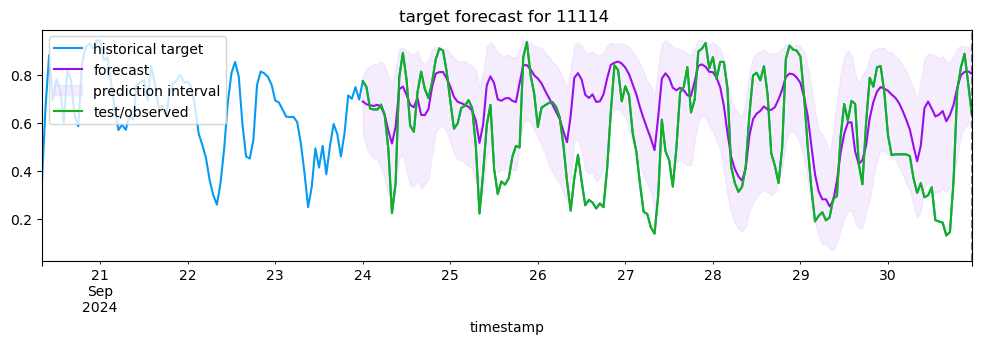

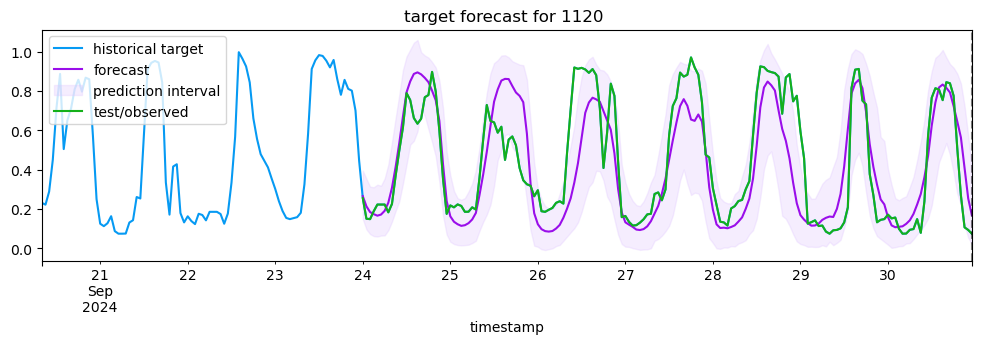

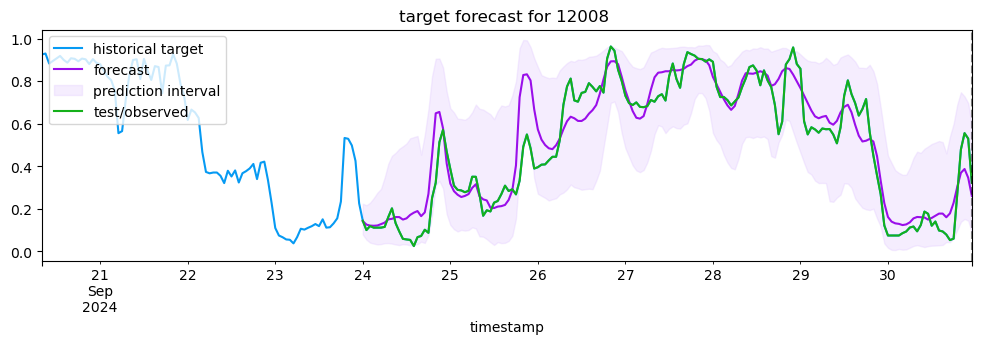

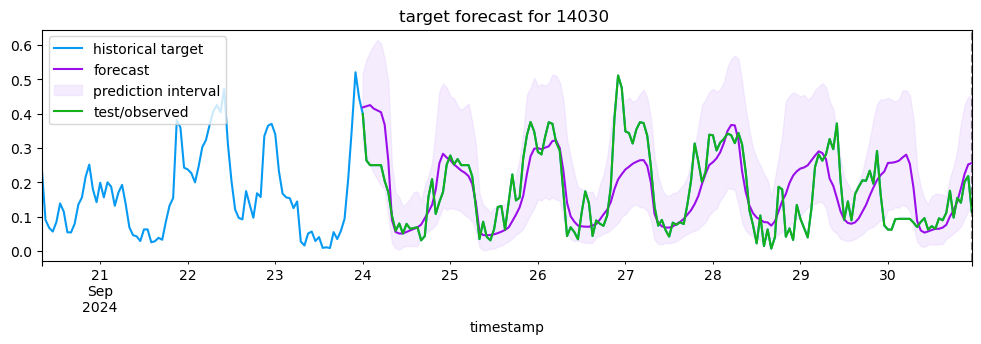

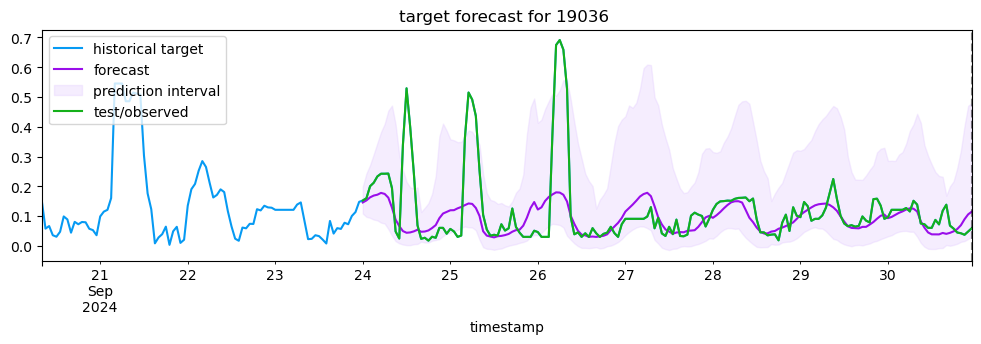

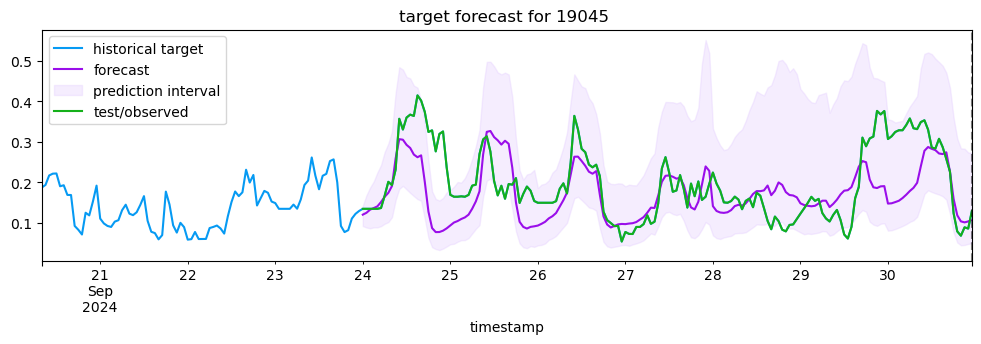

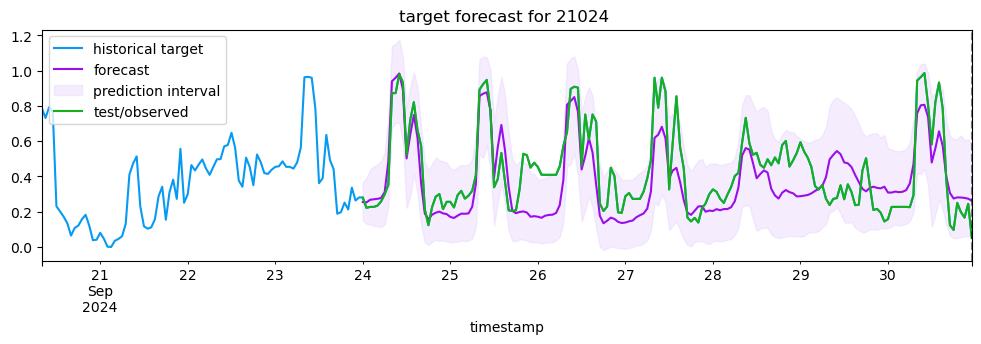

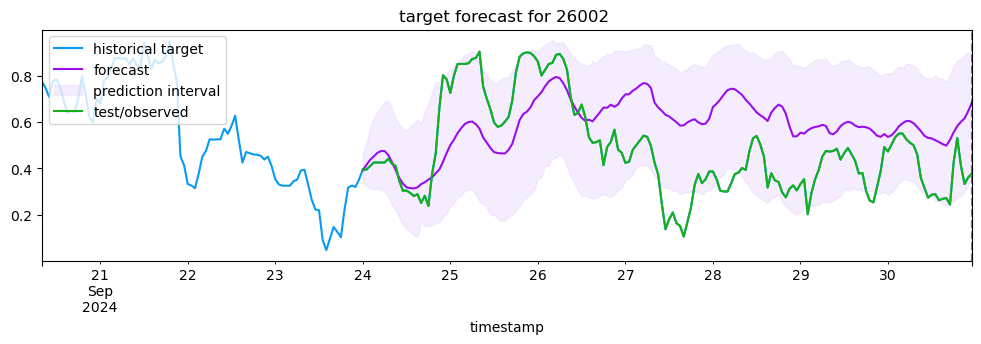

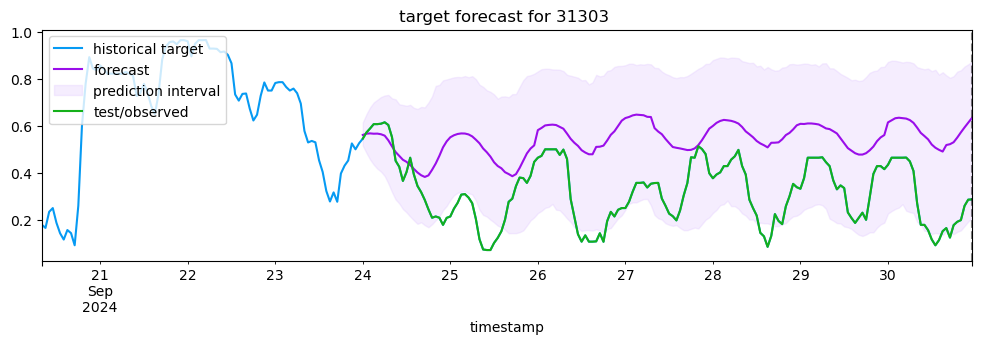

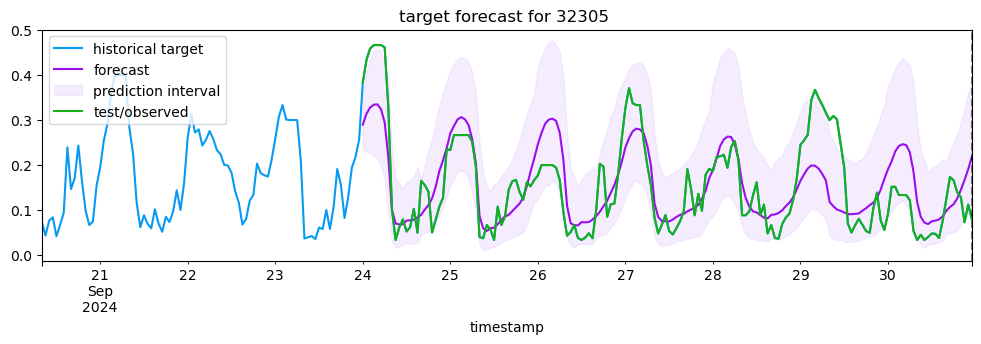

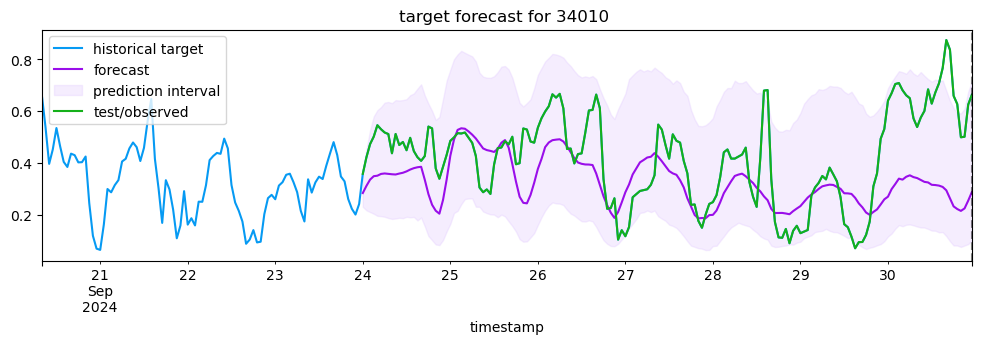

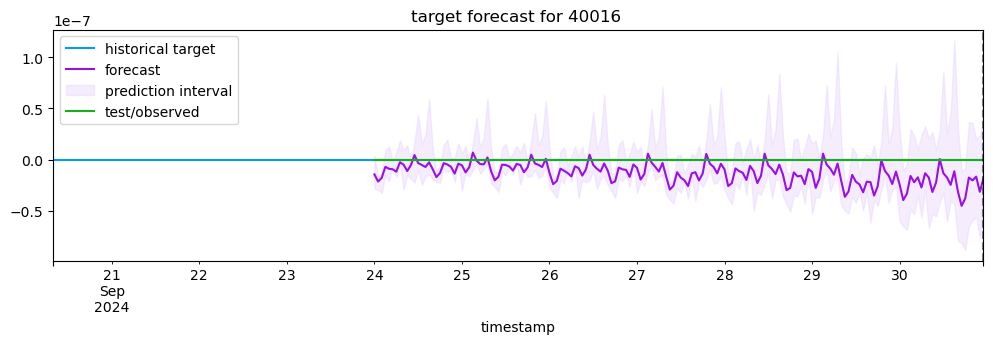

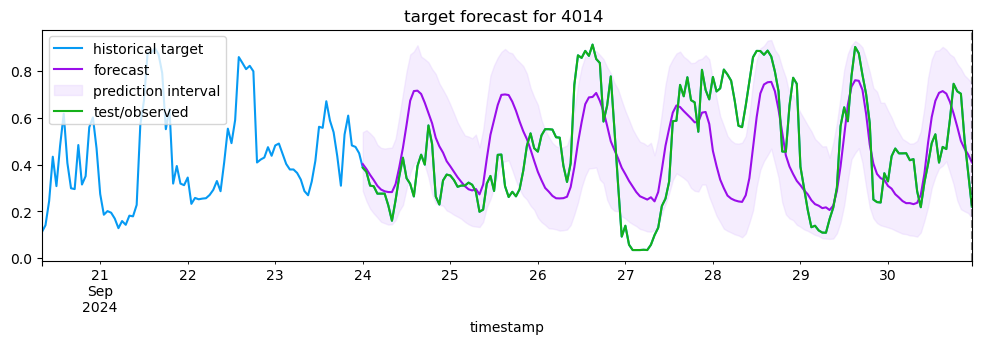

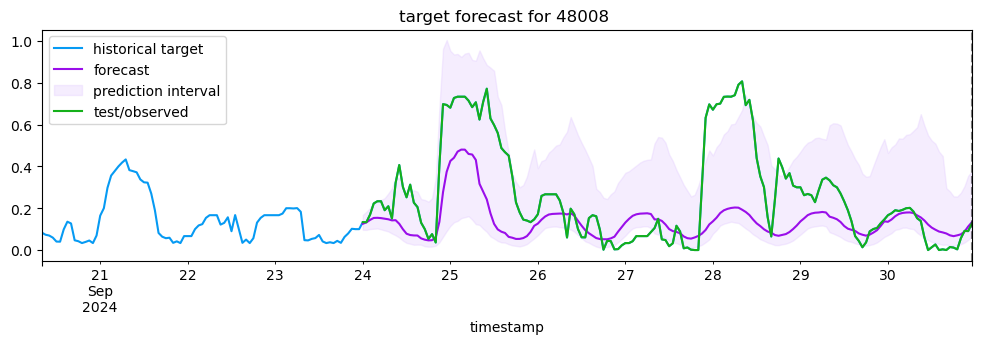

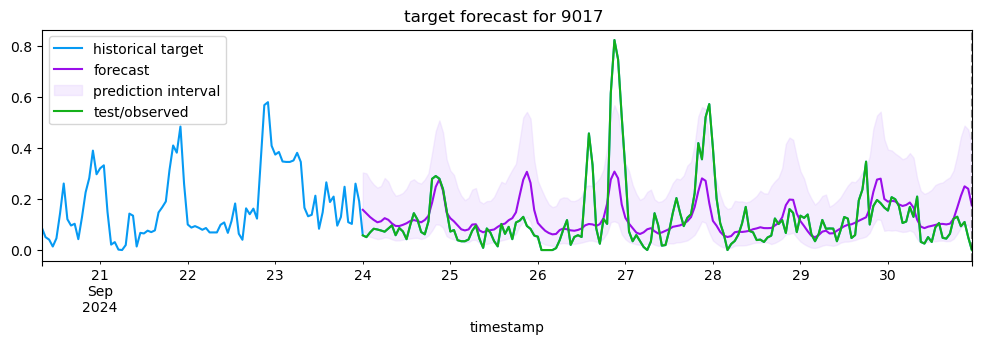

In [9]:
for s in station_list:
    plot_forecast_with_test(
        context_df,
        pred_df,
        test_df,
        target_column="target",
        timeseries_id=s
    )

In [10]:
capacites = df_sample.groupby("code_station")["capacite"].max().to_dict()

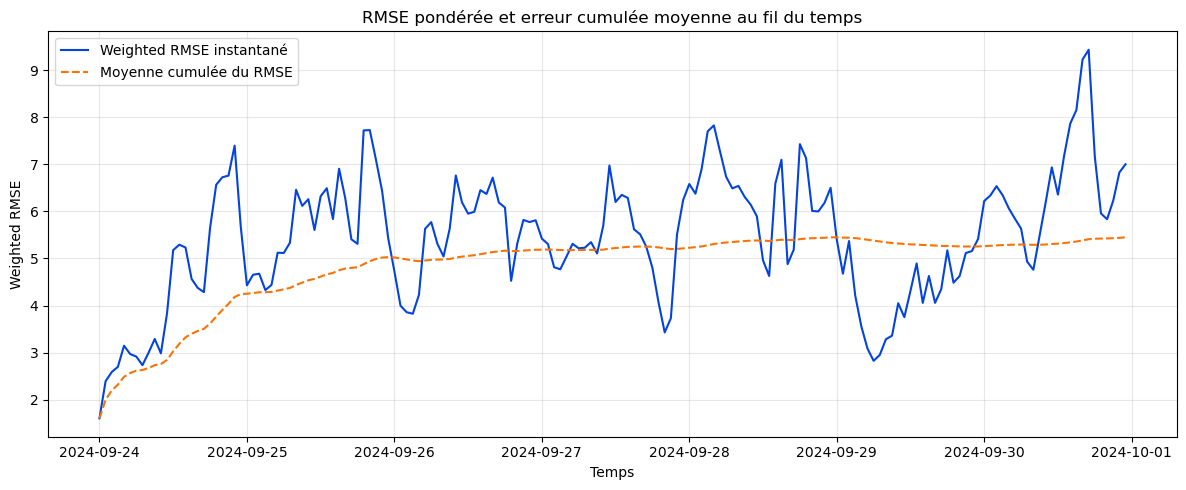

,timestamp,weighted_rmse,cumulative_rmse_mean
0,2024-09-24 00:00:00,1.603142,1.603142
1,2024-09-24 01:00:00,2.391393,1.997267
2,2024-09-24 02:00:00,2.586918,2.193818
3,2024-09-24 03:00:00,2.696914,2.319592
4,2024-09-24 04:00:00,3.145531,2.484780
...,...,...,...
163,2024-09-30 19:00:00,5.957202,5.422970
164,2024-09-30 20:00:00,5.834061,5.425461
165,2024-09-30 21:00:00,6.231383,5.430316
166,2024-09-30 22:00:00,6.828479,5.438688


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def plot_weighted_rmse_over_time(
    test_df, pred_df, capacity_dict,
    target_column='target', id_column='item_id', timestamp_column='timestamp'
):
    # Assure que les timestamps sont bien au format datetime
    test_df = test_df.copy()
    pred_df = pred_df.copy()
    test_df[timestamp_column] = pd.to_datetime(test_df[timestamp_column])
    pred_df[timestamp_column] = pd.to_datetime(pred_df[timestamp_column])

    # Liste pour stocker les résultats temporels
    rmse_by_time = []

    # Boucle sur chaque timestamp commun entre test et pred
    for t in sorted(set(test_df[timestamp_column]) & set(pred_df[timestamp_column])):
        # Extraire les valeurs réelles et prédites à cet instant
        test_t = test_df[test_df[timestamp_column] == t]
        pred_t = pred_df[pred_df[timestamp_column] == t]

        weighted_errors = []
        weights = []

        for station in test_t[id_column].unique():
            # valeurs réelles
            y_true = test_t.loc[test_t[id_column] == station, target_column]
            # prédiction médiane
            y_pred = pred_t.loc[pred_t[id_column] == station, "0.5"]

            if len(y_true) == 0 or len(y_pred) == 0:
                continue

            # erreur au carré
            mse = mean_squared_error(y_true, y_pred)

            # poids = capacité
            cap = capacity_dict.get(station, 1)
            weighted_errors.append(mse * cap*cap)
            weights.append(cap)

        if weights:
            # RMSE pondérée à cet instant
            weighted_rmse_t = np.sqrt(np.mean(weighted_errors))
            rmse_by_time.append((t, weighted_rmse_t))

        # Créer un DataFrame temporel
    rmse_time_df = pd.DataFrame(rmse_by_time, columns=[timestamp_column, "weighted_rmse"])

    # Calcul de la moyenne cumulative
    rmse_time_df["cumulative_rmse_mean"] = rmse_time_df["weighted_rmse"].expanding().mean()

    # Tracé des deux courbes
    plt.figure(figsize=(12, 5))
    plt.plot(rmse_time_df[timestamp_column], rmse_time_df["weighted_rmse"], label="Weighted RMSE instantané", color="xkcd:blue")
    plt.plot(rmse_time_df[timestamp_column], rmse_time_df["cumulative_rmse_mean"], label="Moyenne cumulée du RMSE", color="xkcd:orange", linestyle="--")

    plt.title("RMSE pondérée et erreur cumulée moyenne au fil du temps")
    plt.xlabel("Temps")
    plt.ylabel("Weighted RMSE")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return rmse_time_df

plot_weighted_rmse_over_time(
    test_df, pred_df, capacites
)

In [8]:
# Visualization helper function
import matplotlib.pyplot as plt

def plot_forecast_no_test(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "item_id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    # Historique
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    # Prévisions
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[["0.1", "0.5", "0.9"]]

    # Couper la série historique pour ne garder que les derniers points
    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    ts_context = ts_context.iloc[start_idx:]
    ts_pred = ts_pred[ts_pred.index >= last_date]

    # Plot
    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_pred["0.5"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.3,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    plt.show()

def plot_forecast_with_test(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "item_id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    # Historique
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    # Prévisions
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[["0.1", "0.5", "0.9"]]

    # Série de test (réelle future)
    ts_test = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    # Couper la série historique pour ne garder que les derniers points
    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    ts_context = ts_context.iloc[start_idx:]

    # Plot
    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()

    # Historique
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")

    # Prévisions
    ts_pred["0.5"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.3,
        label="prediction interval",
        color="xkcd:light lavender",
    )

    # Série de test (réelle)
    ts_test.plot(ax=ax, label="test/observed", color="xkcd:green")

    # Ligne verticale à la fin de l'historique
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)

    # Légende et titre
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    plt.show()
